# Extracting Data from Aligned EEG

Loading EEG from FIF (aligned) files with montage, computing frequency bands, including around specific timestamps

**Questions / Interests:**
* When computing frequences, what are the timestamps?
* Possibility / relevance of using overlap windows for the computation (=> more frequent values)
* Which merge between electrodes?
* Using IPU ends (or other markers) for specific location computation?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import shutil
import re
import json
import numpy as np
import pandas as pd
import audiofile
from tqdm import tqdm
import datetime
import copy
from ast import literal_eval

import scipy.signal as sig 

import seaborn as sns
import matplotlib.pyplot as plt
import IPython

In [3]:
import mne
#%matplotlib qt

In [14]:
SRC_PATH = "/Users/eliot/Documents/projects/brainkt-expe/src"
sys.path.append(SRC_PATH)
# reading / writing textgrids

from eeg_base import _read_participant_eeg
from textgrid_utils import read_tier

In [15]:
video_path = "../data/video"
aaudio_folder = "../data/audio-aligned"
teeg_folder = "../data/eeg-aligned"
e4_folder = "../data/empatica-aligned"
text_folder = "../data/transcript/"
skip_sessions = []
markers_path = "../data/video/markers_from_video_start.csv"
markers = pd.read_csv(markers_path)
sq_path = "../data/video/cadrage-video.xlsx"
signal_quality = pd.read_excel(sq_path, sheet_name="Signal Quality")

In [ ]:
# get bad channel dataframe
signal_quality.Impedence_High = signal_quality.Impedence_High.apply(lambda x: [] if isinstance(x,float) else ([f"{l}{n}" for l in ['A','B'] for n in range(1,33)] if x == 'all' else x.split(',')))
signal_quality.Saturating = signal_quality.Saturating.apply(lambda x: [] if isinstance(x,float) else ([f"{l}{n}" for l in ['A','B'] for n in range(1,33)] if x == 'all' else x.split(',')))
# only labelling Saturating as 'bad' channels
signal_quality['bad_channels'] = signal_quality.apply(lambda x: [f"{x.AdBox}-{ch}" for ch in x.Saturating], axis=1)
# ---- result
bad_ch = signal_quality.groupby(['Date','Dyad']).agg({'bad_channels': 'sum'})

In [6]:
markers.head()

,file,Start,Watch p1,Watch p2,Clap,Start Task 1,End Task 1,End Task 2,Stop,Actual End Task 1
0,221116_CGLS,0.0,3.04,12.52,52.20,62.84,1016.16,1889.76,1891.88,NaN
1,221117_TFGG,0.0,11.60,0.96,49.64,69.84,1063.60,1972.56,1975.00,NaN
2,221118_GDNF,0.0,30.64,8.32,65.16,82.40,891.52,1929.28,1935.00,NaN
3,221118_VPET,0.0,1.08,2.92,55.16,72.72,1009.20,1999.36,2005.00,NaN
4,221121_JPMC,0.0,2.84,7.12,43.28,54.12,916.64,1893.20,1895.00,NaN


## Functions

In [ ]:
# get channels names for computed data
def fq_to_df(d:np.array):
    col_names = list(set(d.info['ch_names']) - set(d.info['bads']) - set(['1-EXG1','1-EXG2','1-EXG3','Status']))
    if d.shape[1] > 5:
        col_names = freqs
    else:
        col_names = ["delta", "theta", "alpha", "sigma", "beta"]
    

In [46]:
def compute_psd_bands(psds:np.array, freqs) -> np.array:
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 5.0],
                    "theta": [5.0, 8.0],
                    "alpha": [8.0, 13.0],
                    "sigma": [13.0, 16.0],
                    "beta": [16.0, 30.0]}
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)
    # Compute by bands
    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, (freqs >= fmin) & (freqs < fmax), :].mean(axis=1)
        X.append(psds_band.reshape(len(psds), 1, -1))
    Y = np.concatenate(X, axis=1)
    return Y # still lacking timestamps

In [141]:
def psd_window(data, tmin:float=0, tmax:float=None, nvps:int=1):
    """
    Compute 

    Input:
        nvps: int, number of values per second; default 1. If > 1 overlapping computation windows
    """
    sfreq = data.info['sfreq']
    if tmax is None:
        tmax = data.get_data().shape[1] / sfreq
    if (tmax-tmin) % 1 != 0:
        tmax = tmax - ((tmax-tmin) % 1)
    fracs = np.array(range(0,nvps))/nvps
    dfs = []
    nshape = None
    t_all = None
    for x in fracs:
        # need to check the number of seconds is integer
        tmin_ = tmin + x
        tmax_ = tmax if x == 0 else (tmax-1+x) # making sure does not exceed duration of data
        t = np.arange(tmin_+0.5,tmax_+0.5)
        psds = data.copy().crop(tmin=tmin_, tmax=tmax_).compute_psd(
            fmin=0.5, fmax=45., picks='eeg', average=None, n_fft=int(sfreq)).get_data()
        # Store psd
        if nshape is None:
            nshape = psds.shape
        elif psds.shape[-1] < nshape[-1]:
            # adding 0 at the end, 
            psds = np.concatenate((psds,np.zeros((nshape[0],nshape[1],nshape[-1]-psds.shape[-1]))),axis=-1)
        elif psds.shape[-1] > nshape[-1]:
            raise IndexError(f"Shape issue - {psds.shape} should be less than {nshape}")
        dfs.append(psds)
        # Store time
        t_all = t if t_all is None else np.concatenate((t_all, t), axis=None)

    dfs = tuple([np.expand_dims(df, axis=-1) for df in dfs])
    dfs = np.concatenate(dfs, axis=-1).reshape(nshape[0], nshape[1], nshape[-1]*len(fracs))
    # removing end 0
    dfs = dfs[:,:,:t_all.shape[0]]

    return dfs, np.sort(t_all)


## Tests

Montage Diagram:

<img src="https://www.researchgate.net/profile/Jose-Del-R-Millan/publication/330340445/figure/fig1/AS:714229665517574@1547297030604/64-EEG-Electrodes-layout-extended-10-20-international.ppm" height="500px">

In [19]:
vfolder = '221116_CGLS'
date, group = vfolder.split('_')
part = 1
partl = group[(part-1)*2:(part-1)*2+2]
mark = markers.loc[markers.file == vfolder].iloc[0]

In [20]:
mark

file                 221116_CGLS
Start                        0.0
Watch p1                    3.04
Watch p2                   12.52
Clap                        52.2
Start Task 1               62.84
End Task 1               1016.16
End Task 2               1889.76
Stop                     1891.88
Actual End Task 1            NaN
Name: 0, dtype: object

In [18]:
p1_spk = read_tier(os.path.join(text_folder, f"bkt-{date}-{group}.TextGrid"), tier_name=f"aligned-{partl}")
p1_spk.head()

,file,tier,start,stop,text
0,bkt-221116-CGLS.TextGrid,aligned-CG,0.000,0.715,"En même temps, ouais."
1,bkt-221116-CGLS.TextGrid,aligned-CG,33.780,34.595,Je
2,bkt-221116-CGLS.TextGrid,aligned-CG,34.920,37.830,me suis dit d'être déjà hier pour une autre ex...
3,bkt-221116-CGLS.TextGrid,aligned-CG,45.275,46.795,juste franchement se lever les cheveux normale...
4,bkt-221116-CGLS.TextGrid,aligned-CG,69.370,70.930,"Attends, c'est en train de charger"


In [23]:
p1_ipu_end = p1_spk[(p1_spk.stop > mark['Start Task 1']) & (p1_spk.stop < mark['End Task 2'])].stop.tolist()
print(p1_ipu_end[10:20])

[113.4, 128.98, 132.055, 138.44, 140.42, 141.7, 148.08, 149.225, 152.81, 167.38]


In [24]:
window = 5
date_mid = p1_ipu_end[11]
date_start = date_mid - window
date_stop = date_mid + window

In [7]:
p1 = _read_participant_eeg(date, group, part)

Opening raw data file ../data/eeg-aligned/bkt-221116-CGLS-p1-raw.fif...
Isotrak not found
    Range : 25879 ... 3900449 =     12.636 ...  1904.516 secs
Ready.
Reading 0 ... 3874570  =      0.000 ...  1891.880 secs...


In [62]:
d = p1.copy()
d.crop(tmin=date_start, tmax=date_stop)

<Raw | bkt-221116-CGLS-p1-raw.fif, 68 x 20686 (10.1 s), ~10.8 MB, data loaded>

In [63]:
spectrum = d.compute_psd(fmin=0.5, fmax=45., picks='eeg', average=None, n_fft=int(d.info['sfreq']))
print(spectrum.shape)
psds, freqs = spectrum.get_data(return_freqs=True)
# choix de n_fft en relation avec la fenêtre temporelle : f = 1/T donc si n_fft = 2 sfreq alors window size = 2s
# Function help: https://mne.discourse.group/t/band-power-continuous-data/3426/5
# Documentation: https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html#mne.time_frequency.psd_array_welch

Effective window size : 1.000 (s)
(63, 45, 10)


Aggregating Welch estimates (median) before plotting...


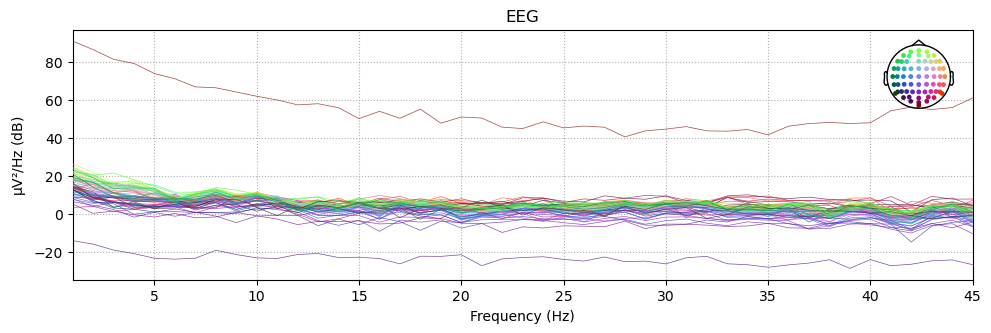

In [27]:
spectrum.plot(ci=None, show=False, average=False, spatial_colors=True)

Effective window size : 1.000 (s)


<MNELineFigure size 1000x350 with 0 Axes>

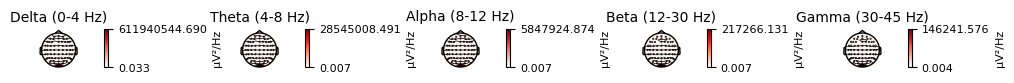

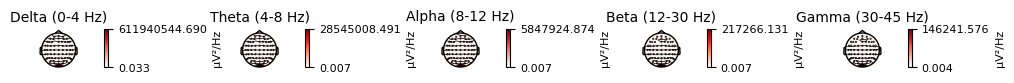

In [28]:
stopomap = d.compute_psd(fmin=0.5, fmax=45., picks='eeg', average='mean', n_fft=int(d.info['sfreq']))
plt.clf()
stopomap.plot_topomap(ch_type='eeg', agg_fun=np.median)

In [72]:
m,n,r = psds.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),psds.reshape(m*n,-1)))
#out_df = pd.DataFrame(out_arr)
out_df = pd.DataFrame(out_arr,columns=['a', 'b', 'c'])

ValueError: Shape of passed values is (2835, 11), indices imply (2835, 3)

In [81]:
np.expand_dims(psds, axis=-1)

(63, 45, 10, 1)

In [142]:
a, t = psd_window(p1, nvps=3)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


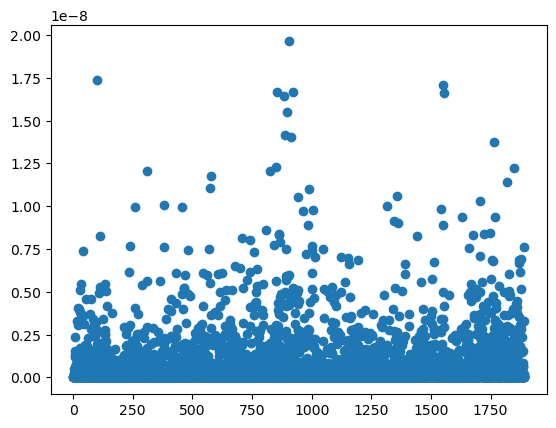

In [144]:
plt.scatter(t, a[1,1,:])
plt.show()

In [154]:
fqb = compute_psd_bands(a, np.arange(1.,45.+1))

In [151]:
idx = np.where(np.logical_and(t >= date_start, t <= date_stop))[0]
#date_mid = p1_ipu_end[11]
#date_start = date_mid - window
#date_stop = date_mid + window)

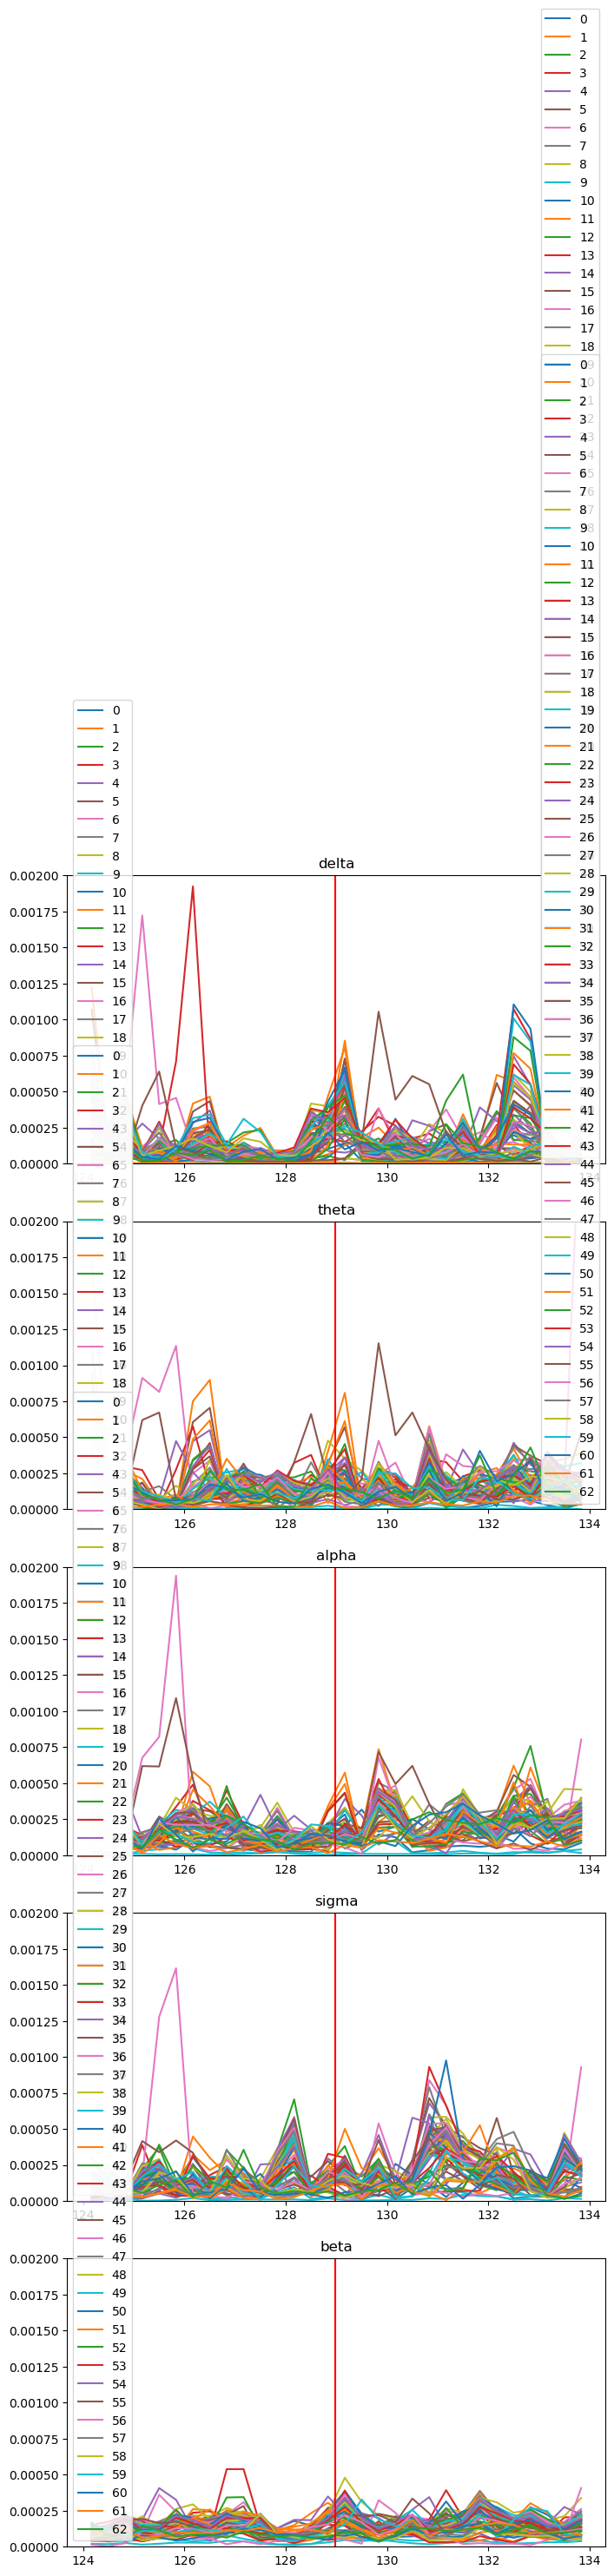

In [174]:
fix, ax = plt.subplots(5,1, figsize=(8,25))
title = ["delta","theta","alpha","sigma","beta"]
for i in range(5):
    pd.DataFrame(fqb[:,i,idx].T, index=t[idx]).plot(ax=ax[i])
    ax[i].set_title(title[i])
    ax[i].axvline(x=date_mid, c='red')
    ax[i].set_ylim(0,0.002)
plt.show()

Ideas:
* Compute around each IPU end (location) - questions about that: 
    1) overlaps
    2) 
* Compute along and try to correlate to high entropy? 
    1) how to store data in between scripts - space required to compute for all participants
    2) how to treat participants (pairs / all )
    <br>$\rightarrow$ load word entropy and plot / correlate? - for each electrode